# Unveiling Academic and Family Patterns: A Comprehensive Analysis of Student Alcohol Consumption in Math vs Portuguese Lesson Dataset

### by Brian Adhitya, Wyatt Howell, Brian Ko, Nishanth Selvakumar

### Introduction

Alcohol consumption has been high around the world, especially for **students**. Student alcohol consumption has been a subject of significant concern and research interest due to its potential implications for academic success, health outcomes, and overall student well-being. The college and university years often coincide with a period of newfound independence and exploration, where students navigate social, academic, and personal challenges. This transitional phase can be accompanied by changes in lifestyle and behavior, including patterns of alcohol consumption. Understanding the factors that influence student alcohol consumption is essential for developing **targeted interventions** and **support mechanisms**.

> Explore why students drink – from academic stress to social habits. This dataset provides insights into the real factors influencing alcohol consumption among students.

With this analysis, we are trying to gain insights on what actually causes this students to drink, and what factors will influence their alcohol consumptions. There are numerous factors that will influence a student to drink, or not to drink. This data analysis also aims to contribute to this crucial area of understanding by examining a comprehensive dataset focused on students' behaviour and circumstances. By uncovering patterns and trends, we seek to provide everyone with valuable information to inform targeted interventions and support systems that promote a healthy, thriving, and of course, **alcohol-free** student community. Recognizing the unique challenges and opportunities that students face, this analysis endeavors to advance our understanding of student alcohol consumption and, in turn, contribute to the creation of environments that foster **holistic student well-being.**

The dataset we are using is a complete, comprehensive, and insightful dataset regarding students' alcohol consumptions. It contains so many interesting information about the students, such as what their parents do, their habits, sex, age and so many others.

> "The data were obtained in a survey of students math and portuguese language courses in secondary school. It contains a lot of interesting social, gender and study information about students." (Cortez & Silva, 2008)

The question we are trying to answer is: **how will family, academic performance, and external factors influence a student's alcohol consumption?**

### Loading libraries

In [1]:
# importing libraries
library(tidyverse)
library(repr)
library(janitor)
library(ggplot2)
library(tidymodels)
library(RColorBrewer)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test


── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ──────

### Preeliminary exploratory data analysis

**1. Loading the Dataset**

We will be working with two csv files, one being the data about the Portuguese language course students.
The second csv file will be the data about the Math course students. We will combine both of these datasets together.

In [2]:
# The Portuguese language dataset
data_por <- read_csv("data/student-por.csv")

# The Math course dataset
data_mat <- read_csv("data/student-mat.csv")

# Joining the datasets and cleaning the names
data <- full_join(data_mat, data_por) |>
        clean_names()

# Initial view of the dataset
head(data)

Rows: 649 Columns: 33
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (17): school, sex, address, famsize, Pstatus, Mjob, Fjob, reason, guardi...
dbl (16): age, Medu, Fedu, traveltime, studytime, failures, famrel, freetime...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 395 Columns: 33
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (17): school, sex, address, famsize, Pstatus, Mjob, Fjob, reason, guardi...
dbl (16): age, Medu, Fedu, traveltime, studytime, failures, famrel, freetime...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(school, sex, age, address, famsize, Pstatus, Medu,
Fedu, Mjob, Fjob, reason, guardian, traveltime, studytim

school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,⋯,famrel,freetime,goout,dalc,walc,health,absences,g1,g2,g3
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GP,F,18,U,GT3,A,4,4,at_home,teacher,⋯,4,3,4,1,1,3,6,5,6,6
GP,F,17,U,GT3,T,1,1,at_home,other,⋯,5,3,3,1,1,3,4,5,5,6
GP,F,15,U,LE3,T,1,1,at_home,other,⋯,4,3,2,2,3,3,10,7,8,10
GP,F,15,U,GT3,T,4,2,health,services,⋯,3,2,2,1,1,5,2,15,14,15
GP,F,16,U,GT3,T,3,3,other,other,⋯,4,3,2,1,2,5,4,6,10,10
GP,M,16,U,LE3,T,4,3,services,other,⋯,5,4,2,1,2,5,10,15,15,15


**2. Cleaning columns and rows**

In [3]:
# Changing categorical values to factor type
data <- data |>
  mutate(across(c(
    school, sex, address, famsize, pstatus, mjob, fjob, reason, guardian,
    schoolsup, famsup, paid, activities, nursery, higher, internet, romantic
  ), as.factor))

glimpse(data)

Rows: 1,044
Columns: 33
$ school     <fct> GP, GP, GP, GP, GP, GP, GP, GP, GP, GP, GP, GP, GP, GP, GP,…
$ sex        <fct> F, F, F, F, F, M, M, F, M, M, F, F, M, M, M, F, F, F, M, M,…
$ age        <dbl> 18, 17, 15, 15, 16, 16, 16, 17, 15, 15, 15, 15, 15, 15, 15,…
$ address    <fct> U, U, U, U, U, U, U, U, U, U, U, U, U, U, U, U, U, U, U, U,…
$ famsize    <fct> GT3, GT3, LE3, GT3, GT3, LE3, LE3, GT3, LE3, GT3, GT3, GT3,…
$ pstatus    <fct> A, T, T, T, T, T, T, A, A, T, T, T, T, T, A, T, T, T, T, T,…
$ medu       <dbl> 4, 1, 1, 4, 3, 4, 2, 4, 3, 3, 4, 2, 4, 4, 2, 4, 4, 3, 3, 4,…
$ fedu       <dbl> 4, 1, 1, 2, 3, 3, 2, 4, 2, 4, 4, 1, 4, 3, 2, 4, 4, 3, 2, 3,…
$ mjob       <fct> at_home, at_home, at_home, health, other, services, other, …
$ fjob       <fct> teacher, other, other, services, other, other, other, teach…
$ reason     <fct> course, course, other, home, home, reputation, home, home, …
$ guardian   <fct> mother, father, mother, mother, father, mother, mother, mot…
$ traveltime <db

**3. Splitting into testing and training**

In [4]:
# splitting the student alcohol consumption data
data_split <- initial_split(data, prop = 0.75, strata = dalc)

# training data
data_training <- training(data_split)

# testing data
data_testing <- testing(data_split)

head(data_training)

school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,⋯,famrel,freetime,goout,dalc,walc,health,absences,g1,g2,g3
<fct>,<fct>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GP,F,18,U,GT3,A,4,4,at_home,teacher,⋯,4,3,4,1,1,3,6,5,6,6
GP,F,17,U,GT3,T,1,1,at_home,other,⋯,5,3,3,1,1,3,4,5,5,6
GP,F,15,U,GT3,T,4,2,health,services,⋯,3,2,2,1,1,5,2,15,14,15
GP,F,16,U,GT3,T,3,3,other,other,⋯,4,3,2,1,2,5,4,6,10,10
GP,M,16,U,LE3,T,2,2,other,other,⋯,4,4,4,1,1,3,0,12,12,11
GP,M,15,U,LE3,A,3,2,services,other,⋯,4,2,2,1,1,1,0,16,18,19


**4. Cleaning and wrangling data**

**5. Visualizing some key points**

We will visualize initially comparing a the number of students who consume alcohol, based on their **living location**, **school**, and **sex**.

`summarise()` has grouped output by 'dalc', 'school', 'sex'. You can override
using the `.groups` argument.


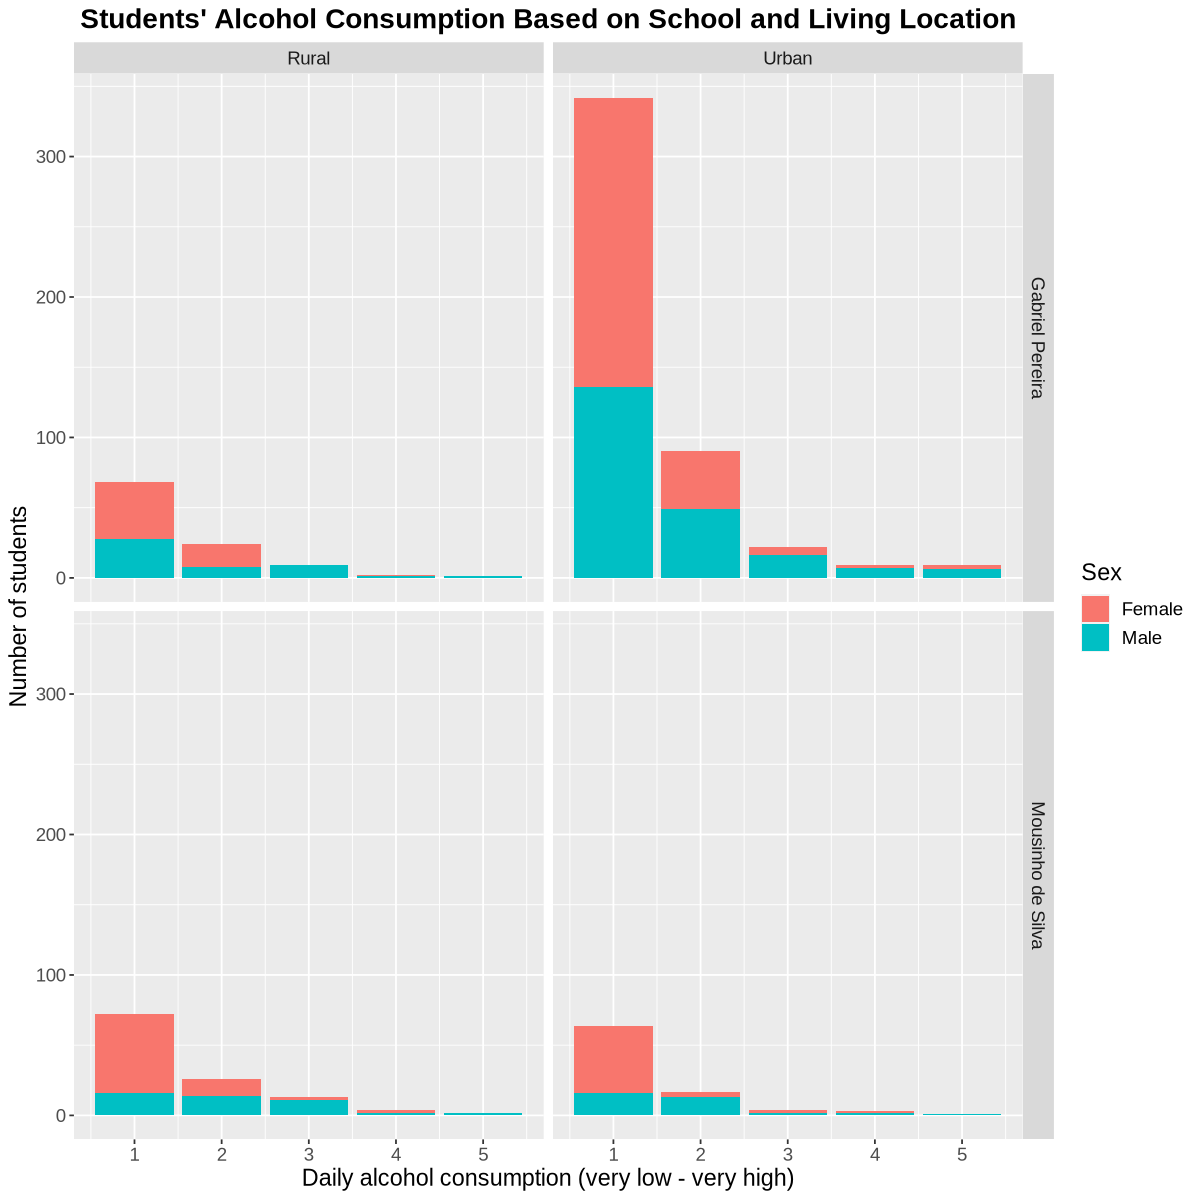

In [5]:
data_initial <- data_training |>
                 group_by(dalc,school,sex,address) |>
                summarize(count = n()) |>
                mutate(school = fct_recode(school, "Gabriel Pereira" = "GP", "Mousinho de Silva" = "MS"),
                       sex = fct_recode(sex, "Female" = "F", "Male" = "M"),
                       address = fct_recode(address, "Rural" = "R", "Urban" = "U"))

options(repr.plot.width = 10, repr.plot.height = 10)

data_initial_plot <- ggplot(data_initial, aes(x=dalc, y=count, fill=sex)) +
                    geom_bar(stat="identity") +
                    labs(x = "Daily alcohol consumption (very low - very high)",
                         y = "Number of students",
                         fill = "Sex",
                         title = "Students' Alcohol Consumption Based on School and Living Location") +
                    facet_grid(rows = vars(school), cols = vars(address)) +
                    theme(text = element_text(size = 14),
                          plot.title = element_text(hjust = 0.5, face = "bold"))

data_initial_plot

One very noticetable thing from this plot is that **urban** students who go to *Garbiel Pereira* have a much higher alcohol consumption rate than those who go to *Mousinho de Silva*. For **rural** students, there's not much of a difference between the two schools. It is not fitting though, to consider which school has a more alcoholic culture within students, especially because we do not yet know the amount of total students who go to each school.

Another interesting key factor is **females students drink much more lightly than male students**.

### Methods

Based on the dataset source in **kaggle** (https://www.kaggle.com/datasets/uciml/student-alcohol-consumption?select=student-merge.R), we can classify the columns as below:

1. **school** - student's school (binary: 'GP' - Gabriel Pereira or 'MS' - Mousinho da Silveira)
2. **sex** - student's sex (binary: 'F' - female or 'M' - male)
3. **age** - student's age (numeric: from 15 to 22)
4. **address** - student's home address type (binary: 'U' - urban or 'R' - rural)
5. **famsize** - family size (binary: 'LE3' - less or equal to 3 or 'GT3' - greater than 3)
6. **pstatus** - parent's cohabitation status (binary: 'T' - living together or 'A' - apart)
7. **medu** - mother's education (numeric: 0 - none, 1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
8. **fedu** - father's education (numeric: 0 - none, 1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
9. **mjob** - mother's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')
10. **fjob** - father's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')
11. **reason** - reason to choose this school (nominal: close to 'home', school 'reputation', 'course' preference or 'other')
12. **guardian** - student's guardian (nominal: 'mother', 'father' or 'other')
13. **traveltime** - home to school travel time (numeric: 1 - <15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - >1 hour)
14. **studytime** - weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)
15. **failures** - number of past class failures (numeric: n if 1<=n<3, else 4)
16. **schoolsup** - extra educational support (binary: yes or no)
17. **famsup** - family educational support (binary: yes or no)
18. **paid** - extra paid classes within the course subject (Math or Portuguese) (binary: yes or no)
19. **activities** - extra-curricular activities (binary: yes or no)
20. **nursery** - attended nursery school (binary: yes or no)
21. **higher** - wants to take higher education (binary: yes or no)
22. **internet** - Internet access at home (binary: yes or no)
23. **romantic** - with a romantic relationship (binary: yes or no)
24. **famrel** - quality of family relationships (numeric: from 1 - very bad to 5 - excellent)
25. **freetime** - free time after school (numeric: from 1 - very low to 5 - very high)
26. **goout** - going out with friends (numeric: from 1 - very low to 5 - very high)
27. **dalc** - workday alcohol consumption (numeric: from 1 - very low to 5 - very high)
28. **walc** - weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)
29. **health** - current health status (numeric: from 1 - very bad to 5 - very good)
30. **absences** - number of school absences (numeric: from 0 to 93)

The two main focus of our data analyis will be **family** and **academics**.
Other supporting factors will include *age*, *sex*, *internet*, and *romantic relationships*.

The methods we will use are listed as follows:

### Expected Outcomes and Significance

What we would like to find:
- How will a student's **family** will affect their alcohol consumption?
- How their **academic success (grades)** will affect their alcohol comsumption?
- Do romantic relationships and internet access also encourage students to consume more alcohol?
- Which factor plays the biggest role in affecting a student's alcohol consumption?
- How do the trends for students' daily alcohol consumption and weekly alcohol consumption differ?

Such findings will be able to create a much bigger impact in the future, such as the policies and actions that an educational institution will take to manage these students' alcohol consumption, and also how families will take to handle their children's alcohol consumption.

Some future questions that this could lead to include:
1. At what age should the minimum requirement for alcohol consumption be?
2. Does spending more time with family mean less alcohol consumption?
3. Do students who drink generally have bad grades?

### Bibliography

P. Cortez and A. Silva. Using Data Mining to Predict Secondary School Student Performance. In A. Brito and J. Teixeira Eds., Proceedings of 5th FUture BUsiness TEChnology Conference (FUBUTEC 2008) pp. 5-12, Porto, Portugal, April, 2008, EUROSIS, ISBN 978-9077381-39-7.

Fabio Pagnotta, Hossain Mohammad Amran.
Email:fabio.pagnotta@studenti.unicam.it, mohammadamra.hossain '@' studenti.unicam.it
University Of Camerino

https://archive.ics.uci.edu/ml/datasets/STUDENT+ALCOHOL+CONSUMPTION